# Exercise 1 - Smoothing and Interpolation

## Introduction
This exercise is about smoothing and interpolating medical images using B-spline basis functions. First, you will implement the principle on a one-dimensional signal, and then expand it to an image in 2D.

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

## Introduction

We use B-spline basis function as 


### Input data and code hints
Import Python libraries

In [1]:
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

np.set_printoptions( suppress=True )
plt.style.use('dark_background') # Dark theme
plt.ion()

Read a 3D image (an MRI scan of the brain) and extract the 2D slice you'll be working with in this exercise:

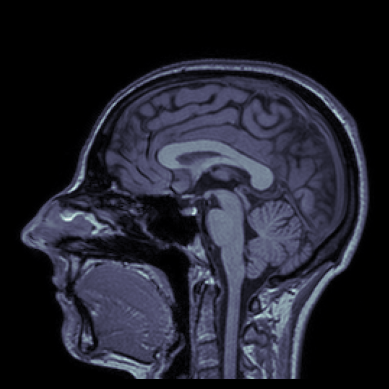

In [2]:
T1_file = './IXI002-Guys-0828-T1.nii.gz'
T1_nib = nib.load( T1_file )
data = T1_nib.get_fdata()

img = data[:, :, 75]
T = np.flipud( img.T )
plt.axis('off')
plt.imshow(T, cmap='bone');

Extract the 1D signal you'll be working with as the middle row of the 2D image

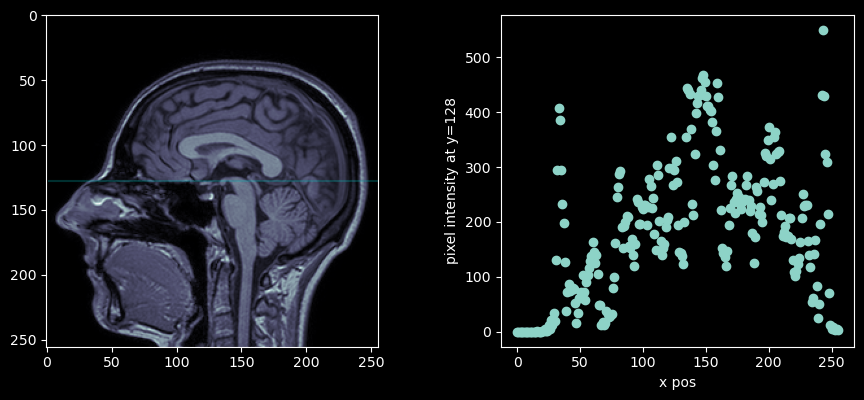

In [3]:
row = round( T.shape[0] / 2 )
t = T[row, :] #pixel intensity at row y = 128

N = t.shape[0]
x = np.arange(0, N)

# plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
fig.tight_layout(pad=5.0)

ax[0].imshow(T, cmap='bone')
ax[0].hlines(row, xmin=1, xmax=255, alpha=0.25, color='c')

ax[1].scatter(x, t)
ax[1].set_xlabel('x pos')
ax[1].set_ylabel('pixel intensity at y={}'.format(row))

plt.show();

---
## Task 1: B-splines basis functions
Implement a function that evaluates the uniform B-spline of orders 0, 1 and 3 at the locations provided in a vector $\mathbf{x}$. 

The function should return a vector $\mathbf{y}$ that is the same length as $\mathbf{x}$:

    def eval_BSpline(x, order=0):

        """
        Evaluates the uniform B-spline of order "order" at the locations in vector "x"
        """

        ...

        return y


Use this function to plot the uniform B-spline of orders 0, 1 and 3 at locations:  $\mathbf{x} = [-3.0,-2.99,-2.98, \ldots, 2.99,3.0]$

> ***Hint:*** use the function ```np.arange()``` to obtain $\mathbf{x}$.

In [4]:
def eval_BSpline(x, order=0):
    """
    Evaluates the uniform B-spline of order "order" at the locations in vector "x"
    """
    import numpy as np
    if order == 0:
        out = np.zeros(x.shape)
        out[(x >= -0.5) & (x < 0.5)] = 1
        out[np.abs(x) == 0.5] = 0.5
        out[(x < -0.5) | (x >= 0.5)] = 0

    elif order == 1:
        out = np.zeros(x.shape)
        mask = np.abs(x) < 1
        out[mask] = 1 - np.abs(x[mask])

    elif order == 3:
        out = np.zeros(x.shape)
        mask1 = np.abs(x) < 0.5
        out[mask1] = 0.75 - x[mask1]**2
        mask2 = (np.abs(x) >= 0.5) & (np.abs(x) < 1.5)
        out[mask2] = 0.5 * (np.abs(x[mask2]) - 1.5)**2
    return out

Text(0.5, 1.0, 'B-spline of order 0')

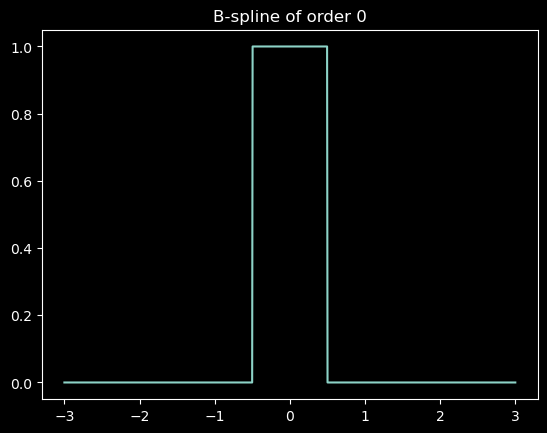

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plotx = np.linspace(-3, 3, 1000)
ploty = eval_BSpline(plotx, order=0)
plt.plot(plotx, ploty)
plt.title('B-spline of order 0')



---
## Task 2: Smoothing
Using the function you wrote above for evaluating a uniform B-spline of order 3, generate $M=6$ basis functions covering the entire domain $x=0,1,\ldots, 255$ of the 1D signal $\mathbf{t}$ defined in the introduction (which has length $N=256$). 

The basis functions should be scaled by a factor $h=(N-1)/(M-1)$, and shifted to be $h$ units apart (see book). 

Collect the obtained basis functions in a $N \times M$ matrix $\boldsymbol{\Phi}$, and plot them.

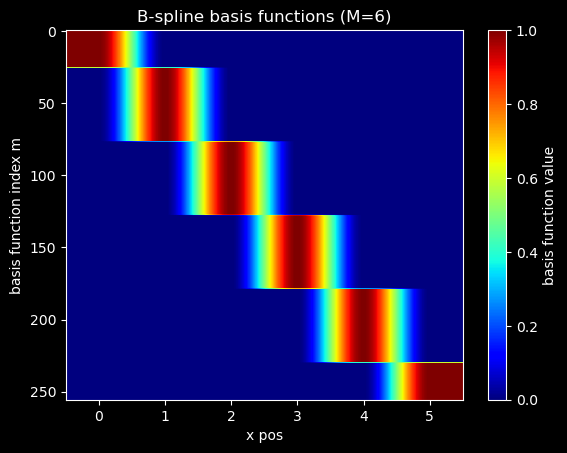

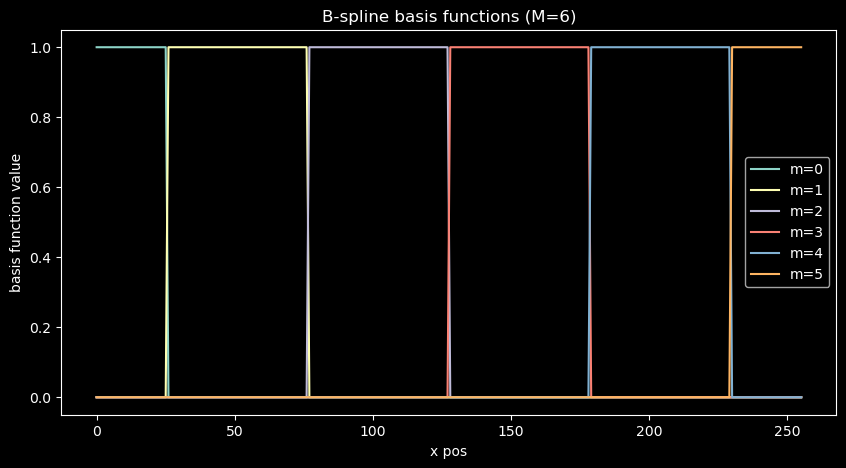

In [6]:
N = len(t)
x = np.linspace(0, N-1, N)
M = 6
phi = np.zeros((N, M))
h = (N-1) / (M-1)
centers = h * np.arange(M)
phi = eval_BSpline((x[:, None] - centers[None, :])/h, order = 0)

plt.imshow(phi, cmap='jet', aspect='auto')
plt.xlabel('x pos')
plt.ylabel('basis function index m')
plt.title('B-spline basis functions (M={})'.format(M))
plt.colorbar(label='basis function value');

# new plot of the basis functions not a heatmap
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5)) 
for m in range(M):
    ax.plot(x, phi[:, m], label='m={}'.format(m))
ax.set_xlabel('x pos')
ax.set_ylabel('basis function value')
ax.set_title('B-spline basis functions (M={})'.format(M))
ax.legend()


Compute:
- the smoothing matrix: $\mathbf{S} = \boldsymbol{\Phi} (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T$
- the smoothed signal:  $\mathbf{\hat{t}} = \mathbf{S} \mathbf{t}$

Plots the results. Also plot the middle row of the smoothing matrix. 

>***Hint:*** 
>
> To compute the solution of a linear equation of the form Ax = b, you can use the following numpy function: ```np.linalg.solve(A, b)```. 
>
> You can also use the matrix inversion function ```np.linalg.inv()```, although this is numerically not the best solution.

Text(0.5, 0, 'x pos')

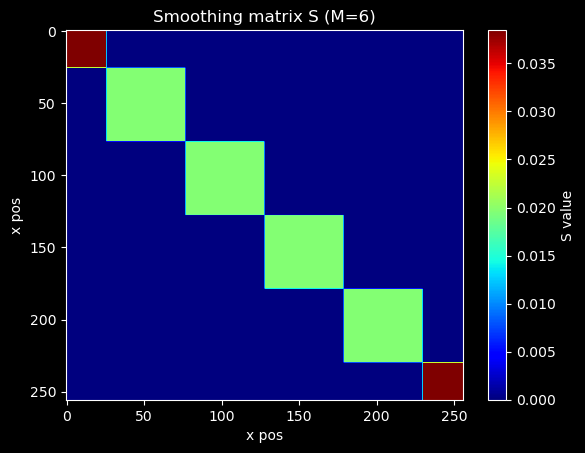

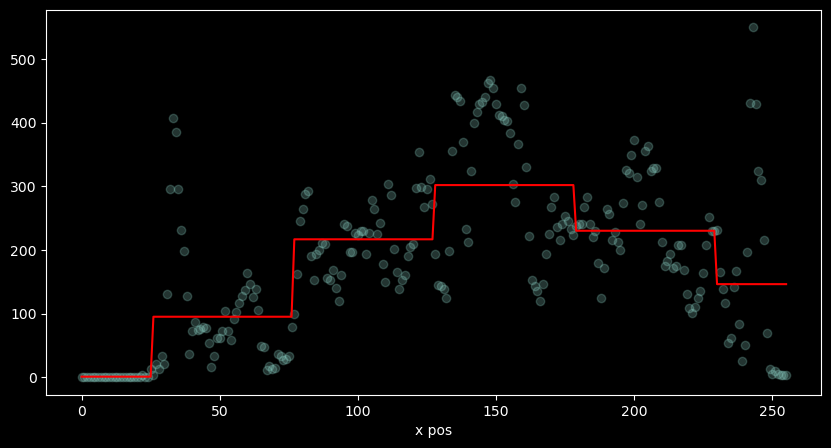

In [7]:
S = phi @ np.linalg.solve(phi.T @ phi, phi.T)
plt.imshow(S, cmap='jet', aspect='auto')
plt.xlabel('x pos')
plt.ylabel('x pos')
plt.title('Smoothing matrix S (M={})'.format(M))
plt.colorbar(label='S value');

t_hat = S @ t
plt.figure(figsize=(10,5))
plt.scatter(x, t, label='data', alpha=0.25)
plt.plot(x, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.xlabel('x pos')

Now repeat the same experiment when more basis functions are used: $M=16$ and $M=52$. 

> ***Q?:*** How does the smoothing behavior change? Explain.

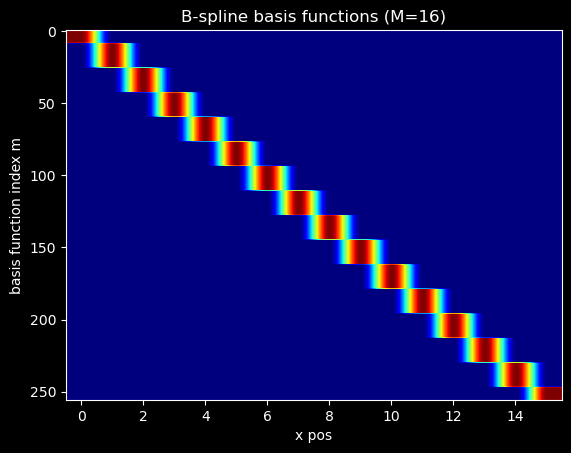

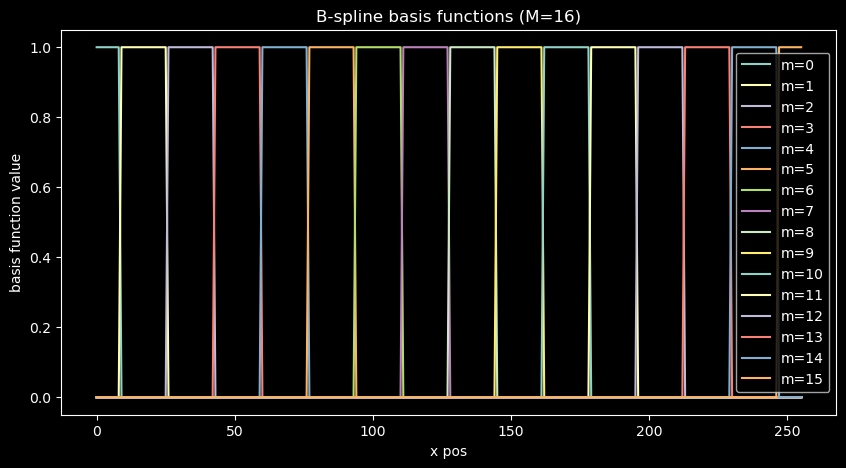

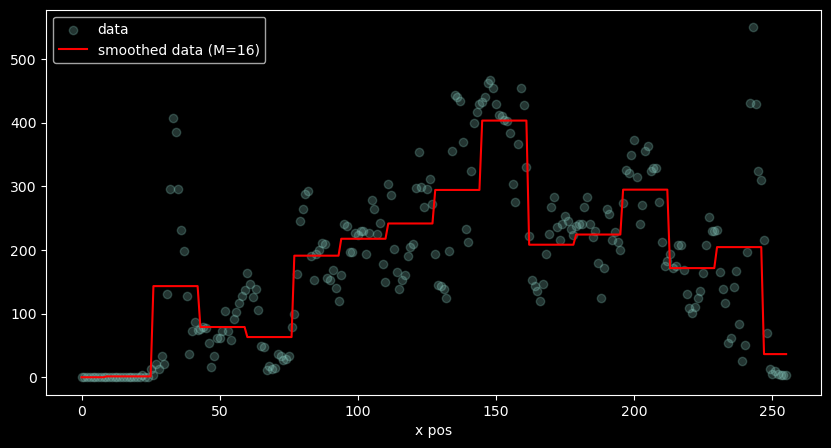

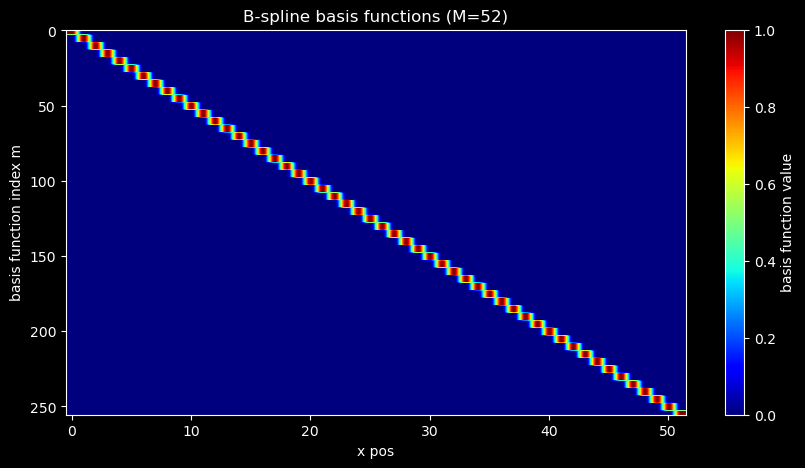

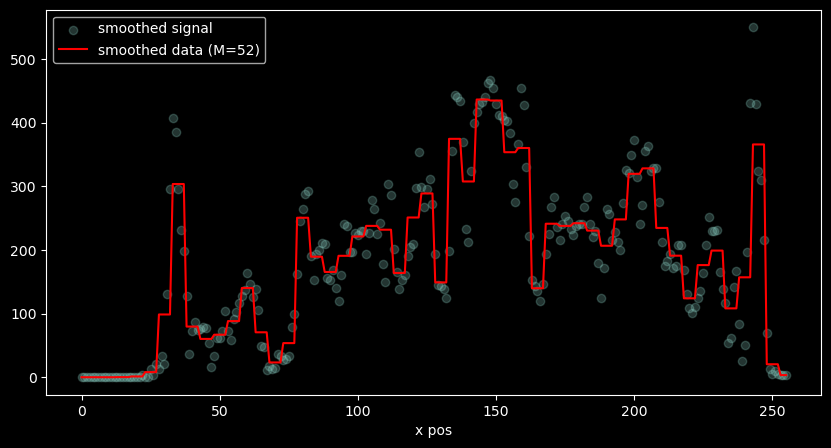

In [8]:
M = 16
phi = np.zeros((N, M))
h = (N-1) / (M-1)
centers = h * np.arange(M)
phi = eval_BSpline((x[:, None] - centers[None, :])/h, order = 0)
plt.imshow(phi, cmap='jet', aspect='auto')
plt.xlabel('x pos')
plt.ylabel('basis function index m')
plt.title('B-spline basis functions (M={})'.format(M))

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
for m in range(M):
    ax.plot(x, phi[:, m], label='m={}'.format(m))
ax.set_xlabel('x pos')
ax.set_ylabel('basis function value')
ax.set_title('B-spline basis functions (M={})'.format(M))
ax.legend()

S = phi @ np.linalg.solve(phi.T @ phi, phi.T)
t_hat = S @ t
plt.figure(figsize=(10,5))
plt.scatter(x, t, label='data', alpha=0.25)
plt.plot(x, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.xlabel('x pos')
plt.legend()

## 52 basis functions
M = 52
phi = np.zeros((N, M))
h = (N-1) / (M-1)
centers = h * np.arange(M)
phi = eval_BSpline((x[:, None] - centers[None, :])/h, order = 0)
plt.figure(figsize=(10,5))
plt.imshow(phi, cmap='jet', aspect='auto')
plt.xlabel('x pos')
plt.ylabel('basis function index m')
plt.title('B-spline basis functions (M={})'.format(M))  
plt.colorbar(label='basis function value');

S = phi @ np.linalg.solve(phi.T @ phi, phi.T)
t_hat = S @ t
plt.figure(figsize=(10,5))
plt.scatter(x, t, label='smoothed signal', alpha=0.25)
plt.plot(x, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.xlabel('x pos')
plt.legend()    

---
## Task 3: Interpolation
Implement B-spline interpolation of the 1D signal $\mathbf{t}$, by evaluating the function $y( x, \mathbf{w})$ at locations $x = [120, 120.01, 120.02, \ldots 140]$

Show your results, along with the corresponding part of the signal $\mathbf{t}$, for three different orders of B-splines: 0, 1 and 3.

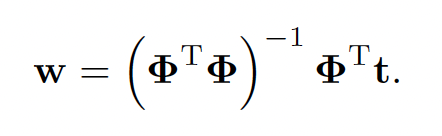

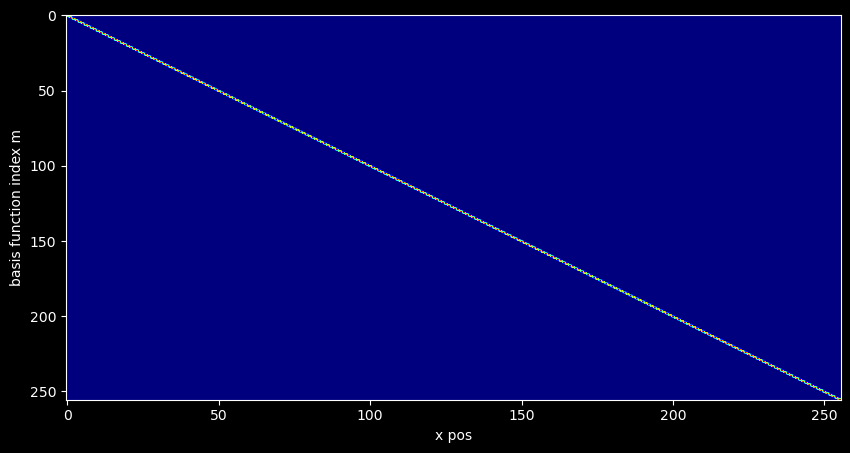

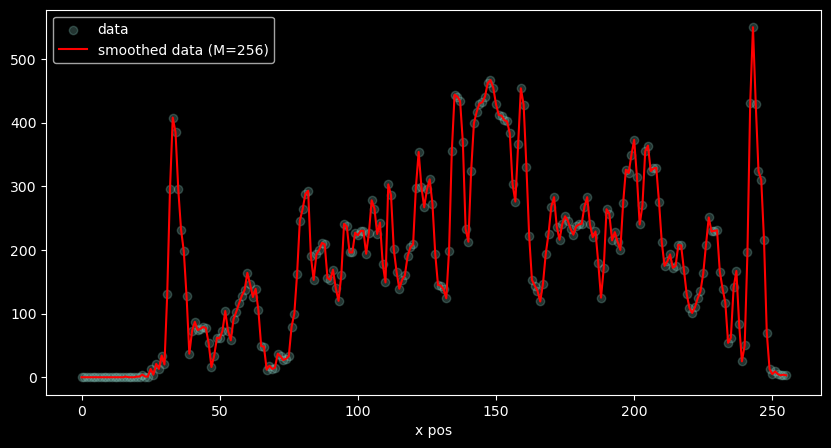

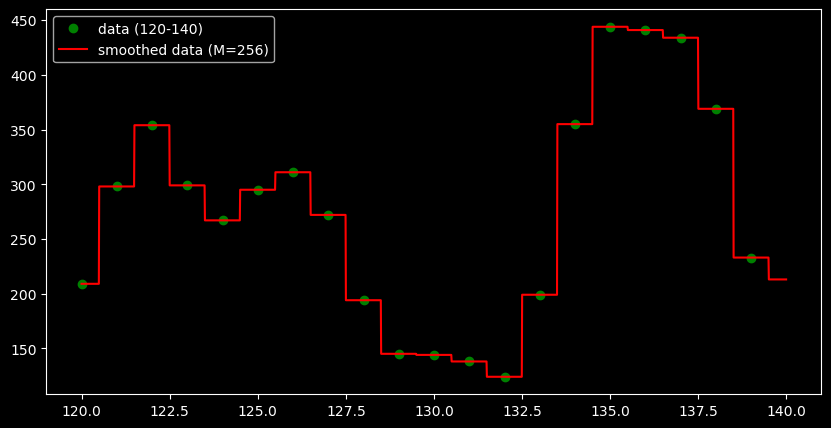

In [9]:
N = len(t)
M = N 
h = (N-1) / (M-1)
x = np.linspace(0, N-1, N)
centers = h * np.arange(M)
phi = eval_BSpline((x[:, None] - centers[None, :])/h, order = 0)

plt.figure(figsize=(10,5))
plt.imshow(phi, cmap='jet', aspect='auto')
plt.xlabel('x pos')
plt.ylabel('basis function index m')

S = phi @ np.linalg.solve(phi.T @ phi, phi.T)
t_hat = S @ t
plt.figure(figsize=(10,5))
plt.scatter(x, t, label='data', alpha=0.25)
plt.plot(x, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.xlabel('x pos')
plt.legend()

w = np.linalg.solve(phi.T @ phi, phi.T @ t) # Using e1 1.3 calculating w

x_1 = np.arange(120, 140, 0.01)
N_1 = len(x_1)
centers = h * np.arange(M)
phi_1 = eval_BSpline((x_1[:, None] - centers[None, :])/h, order = 0)

t_hat = phi_1 @ w # Evaluting new location of x with calculated w(weight) by eq 1.1
plt.figure(figsize=(10,5))
plt.plot(np.arange(120, 140, 1), t[120:140], 'go', label='data (120-140)')
plt.plot(x_1, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.legend()
plt.show()

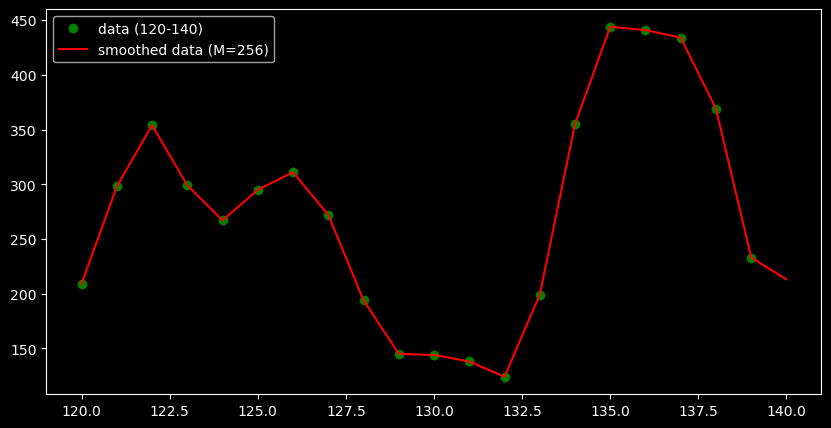

In [10]:
N = len(t)
M = N 
h = (N-1) / (M-1)
x = np.linspace(0, N-1, N)
centers = h * np.arange(M)
phi = eval_BSpline((x[:, None] - centers[None, :])/h, order = 1)


w = np.linalg.solve(phi.T @ phi, phi.T @ t)

x_1 = np.arange(120, 140, 0.01)
N_1 = len(x_1)
centers = h * np.arange(M)
phi_1 = eval_BSpline((x_1[:, None] - centers[None, :])/h, order = 1)


t_hat = phi_1 @ w
plt.figure(figsize=(10,5))
plt.plot(np.arange(120, 140, 1), t[120:140], 'go', label='data (120-140)')
plt.plot(x_1, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.legend()
plt.show()

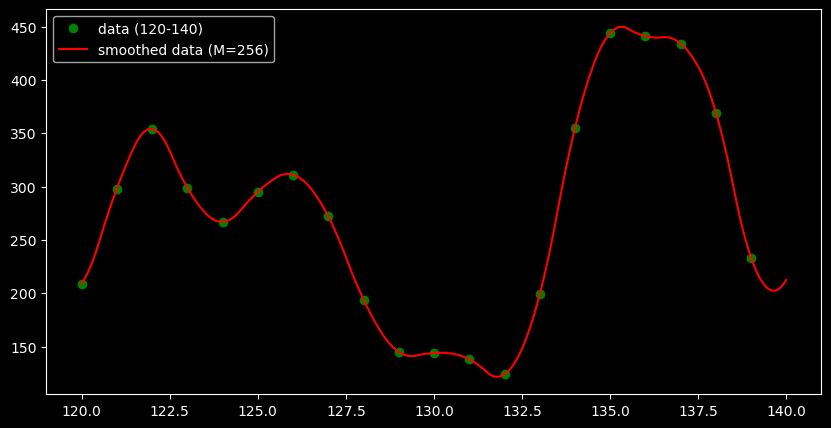

In [11]:
N = len(t)
M = N 
h = (N-1) / (M-1)
x = np.linspace(0, N-1, N)
centers = h * np.arange(M)
phi = eval_BSpline((x[:, None] - centers[None, :])/h, order = 3)


w = np.linalg.solve(phi.T @ phi, phi.T @ t)

x_1 = np.arange(120, 140, 0.01)
N_1 = len(x_1)
centers = h * np.arange(M)
phi_1 = eval_BSpline((x_1[:, None] - centers[None, :])/h, order = 3)

t_hat = phi_1 @ w
plt.figure(figsize=(10,5))
plt.plot(np.arange(120, 140, 1), t[120:140], 'go', label='data (120-140)')
plt.plot(x_1, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.legend()
plt.show()

---
## Task 4: Smoothing in 2D
Now you are going to smooth the 2D image $\mathbf{T}$, which has dimensions $N_1 \times N_2 = 256 \times 256$, with $M_1=M_2=5$ B-spline-based 1D basis functions of order 3 for each direction.

Use the Kronecker product to produce a $N \times M$ matrix $\boldsymbol{\Phi} = \boldsymbol{\Phi}_2 \otimes \boldsymbol{\Phi}_1$, where:
- $N=N_1 N_2$ 
- $M = M_1 M_2$. 

Show a few 2D basis functions contained in the columns of $\boldsymbol{\Phi}$.

>***Hints***:
>* the Kronecker product of two matrices A and B can be calculated with ```np.kron(A, B)```
>* for converting a vectorized basis function ```v``` back into its 2D shape, use ```v.reshape(N_1, N_2, order='F')```
>* the following snippet can be used to show a 2D basis function:
>    ```
>        plt.figure(); 
>        ax = plt.axes(projection='3d'); 
>        ax.plot_wireframe(np.arange(N1).reshape(-1, 1), np.arange(N2).reshape(1, -1), basisFunction)
>
>    ```

(65536, 25)
(256, 5)
(256, 5)


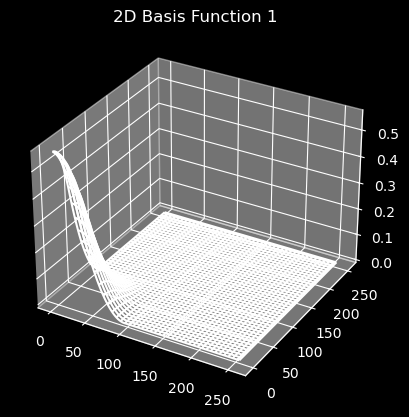

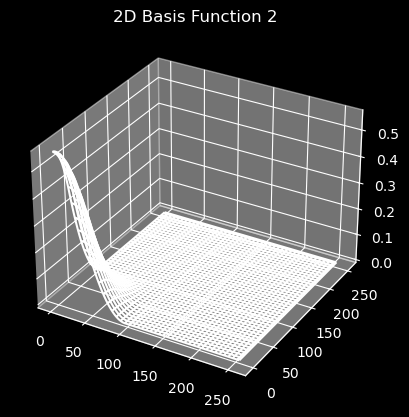

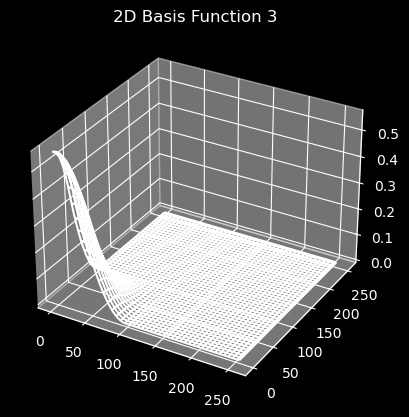

In [12]:
# Use image T
N1, N2 = len(T[1]), len(T[0])
M1, M2 = 5, 5
h1 = (N1-1) / (M1-1)
h2 = (N2-1) / (M2-1)
x1 = np.linspace(0, N1-1, N1)
x2 = np.linspace(0, N2-1, N2)
centers = h * np.arange(M1)
phi1 = eval_BSpline((x1[:, None] - centers[None, :])/h1, order = 3)
phi2 = eval_BSpline((x2[:, None] - centers[None, :])/h2, order = 3)
phi = np.kron(phi1, phi2)
print(phi.shape)
print(phi1.shape)
print(phi2.shape)

def plot_basis_function(basis_function, N1, N2, index):
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(
        np.arange(N1).reshape(-1, 1), 
        np.arange(N2).reshape(1, -1), 
        basis_function
    )
    ax.set_title(f"2D Basis Function {index+1}")
    plt.show()

for i in range(3):  
    basis_function = phi[:, i].reshape(N1, N2, order='F')
    plot_basis_function(basis_function, N1, N2, i)

### 2-D Smoothing with B-splines

* Build 1-D cubic B-spline bases  
  * `Φ₁ ∈ ℝ^{N₁×M₁}` (rows)  
  * `Φ₂ ∈ ℝ^{N₂×M₂}` (cols)

* Combine them with the **Kronecker product**  
  \[
  \Phi = \Phi_{2} \otimes \Phi_{1}
  \]
  * size: \(N = N₁ N₂\), \(M = M₁ M₂\)$

* Each column of `Φ` is one **2-D basis function**, stored as a vector of length `N`.


Now:
- vectorize the 2D image $\mathbf{T}$ into a 1D signal $\mathbf{t}$
- smooth using $\boldsymbol{\Phi}$
- re-arrange the resulting 1D signal $\mathbf{\hat{t}}$ back into a 2D image $\mathbf{\hat{T}}$
- show the result.

>***Hints***: 
>* use ```T.reshape(-1, 1, order='F')``` and ```t.reshape(N_1, N_2, order='F')``` to vectorize and undo the vectorization.
>* do not explicitly compute the smoothing matrix $\mathbf{S}$ as it is very large!! Instead compute the weights $\mathbf{w} = (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T \mathbf{t}$ and expand those to get $\mathbf{\hat{t}} = \boldsymbol{\Phi} \mathbf{w}$.


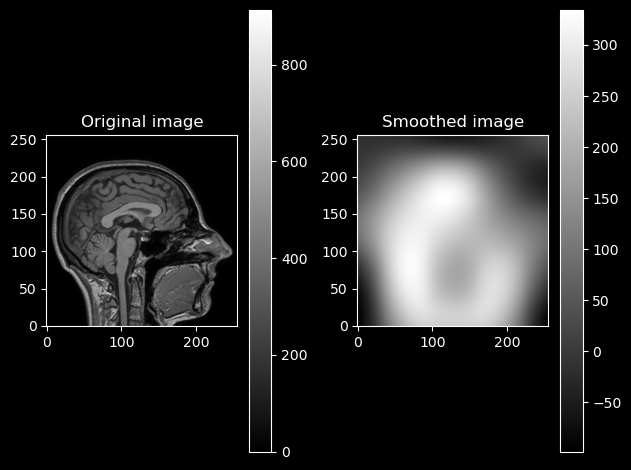

In [13]:
N = 256
M = 5
h = (N-1) / (M-1)
x = np.linspace(0, N-1, N)
phi1 = np.zeros((N, M))
phi2 = np.zeros((N, M))
for m in range(M):
    
    phi1[:, m] = eval_BSpline((x - m * h)/h, order=3)
for m in range(M):
    phi2[:, m] = eval_BSpline((x - m * h)/h, order=3)
phi = np.kron(phi1, phi2)

t = T.reshape(-1, 1, order='F')
w = np.linalg.solve(phi.T @ phi, phi.T @ t)
t_hat = phi @ w # Here we are smoothin by calculated and inverting the whole matrix phi 65536x25, when the basis function increases does the parameters.
T_hat_0 = t_hat.reshape(N1, N2, order='F') # These calculation are costly can in the code we do them more effienctly 
### or calculate like so 
#phi_t = np.transpose(phi)
#S = phi @ np.linalg.inv(phi_t @ phi)@phi_t

#T_smot = S @ t
#T_smooth = T_smot.reshape(N1,N2 , order='F')


plt.figure();
plt.subplot(1,2,1)
plt.imshow(np.rot90(T,2), cmap='gray', origin = 'lower' );# rotate 90 deg
plt.title('Original image')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.rot90(T_hat_0,2), cmap='gray', origin = 'lower');
plt.title('Smoothed image')
plt.colorbar()

plt.tight_layout()
plt.show()


Also perform the same smoothing operation by exploiting the separability of the 2D basis functions, i.e, perform row-wise and then column-wise smoothing instead. 

Show the results, and verify that they are identical (use ```np.allclose()```) 

True


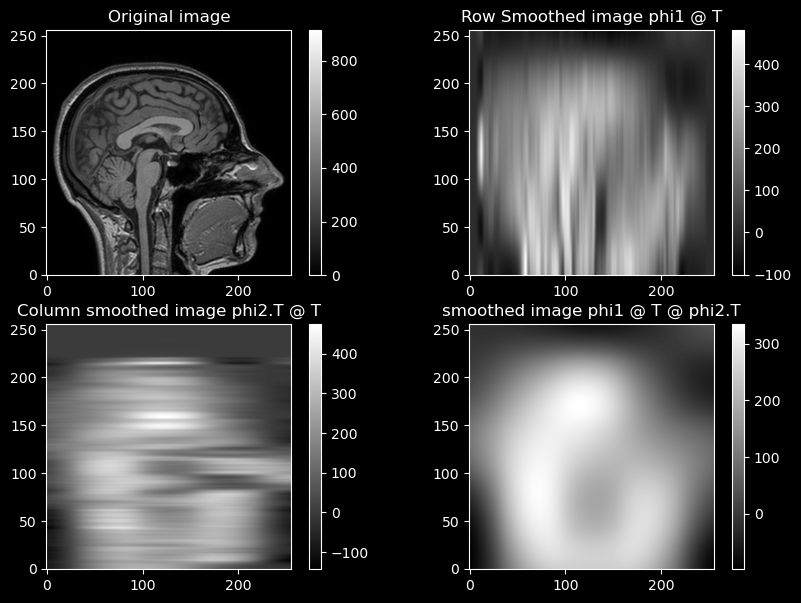

In [14]:
S1 = phi1 @ np.linalg.solve(phi1.T @ phi1, phi1.T) # Here we use the spe
S2 = phi2 @ np.linalg.solve(phi2.T @ phi2, phi2.T)
T_hat_row = S1 @ T
T_hat_col = T @ S2.T
T_hat = S1 @T@ S2.T

print(np.allclose(T_hat, T_hat_0))
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.imshow(np.rot90(T,2), cmap='gray', origin = 'lower' );
plt.title('Original image')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(np.rot90(T_hat_row,2), cmap='gray', origin = 'lower');
plt.title('Row Smoothed image phi1 @ T')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(np.rot90(T_hat_col,2), cmap='gray', origin = 'lower');
plt.title('Column smoothed image phi2.T @ T')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(np.rot90(T_hat,2), cmap='gray', origin = 'lower');
plt.title('smoothed image phi1 @ T @ phi2.T')
plt.colorbar()
plt.savefig("smoothed_images.png", dpi=300, bbox_inches='tight')


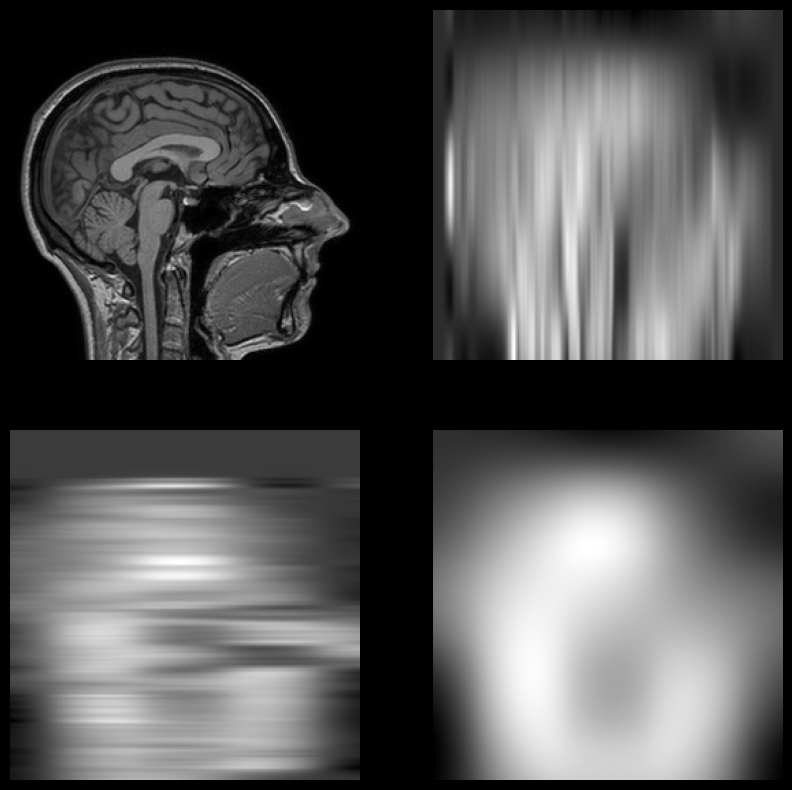

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.rot90(T,2), cmap='gray', origin = 'lower' )
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(T_hat_row,2), cmap='gray', origin = 'lower')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(np.rot90(T_hat_col,2), cmap='gray', origin = 'lower')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(np.rot90(T_hat,2), cmap='gray', origin = 'lower')
plt.axis('off')

plt.savefig("smoothed_images.png", dpi=300, bbox_inches='tight')

---
## Task 5: Interpolation in 2D
For B-spline order 0, 1 and 3, compute the weights $\mathbf{W}$ of the 2D interpolation model fitted to $\mathbf{T}$ by exploiting the separability of its basis functions.

Then show, as an image, interpolated function values $y( \mathbf{x}, \mathbf{w})$ for $\mathbf{x}=(x_1, x_2)^T$ with:
- $x_1=120.0, 120.1, 120.2 \ldots, 130.0$ 
- $x_2=120.0, 120.1, 120.2 \ldots, 130.0$ 

In [16]:
def interpolator(x, h, M, order ):
    centers = h * np.arange(M)
    phi1 = eval_BSpline((x[:, None] - centers[None, :])/h, order = order)
    phi2 = eval_BSpline((x[:, None] - centers[None, :])/h, order = order)
    return phi1, phi2

In [17]:
N = 256
M = N
h = (N-1) / (M-1)
x = np.linspace(0, N-1, N)
x1 = np.arange(120, 130, 0.1)
N_1 = len(x1)
# Order 0
phi1, phi2 = interpolator(x, h, M, 0)
phi1_inv = np.linalg.pinv(phi1.T @ phi1)
phi2_inv = np.linalg.pinv(phi2.T @ phi2)
W0 = phi1_inv @ phi1.T @ T @ phi2 @ phi2_inv

phi1, phi2 = interpolator(x1, h, M, 0)
Y0 = phi1 @ W0 @ phi2.T # separability 

# Order 1
phi1, phi2 = interpolator(x, h, M, 1)
phi1_inv = np.linalg.pinv(phi1.T @ phi1)
phi2_inv = np.linalg.pinv(phi2.T @ phi2)
W1 = phi1_inv @ phi1.T @ T @ phi2 @ phi2_inv

phi1, phi2 = interpolator(x1, h, M, 1)
Y1 = phi1 @ W1 @ phi2.T

# Order 3
phi1, phi2 = interpolator(x, h, M, 3)
phi1_inv = np.linalg.pinv(phi1.T @ phi1)
phi2_inv = np.linalg.pinv(phi2.T @ phi2)
W3 = phi1_inv @ phi1.T @ T @ phi2 @ phi2_inv

phi1, phi2 = interpolator(x1, h, M, 3)
Y3 = phi1 @ W3 @ phi2.T


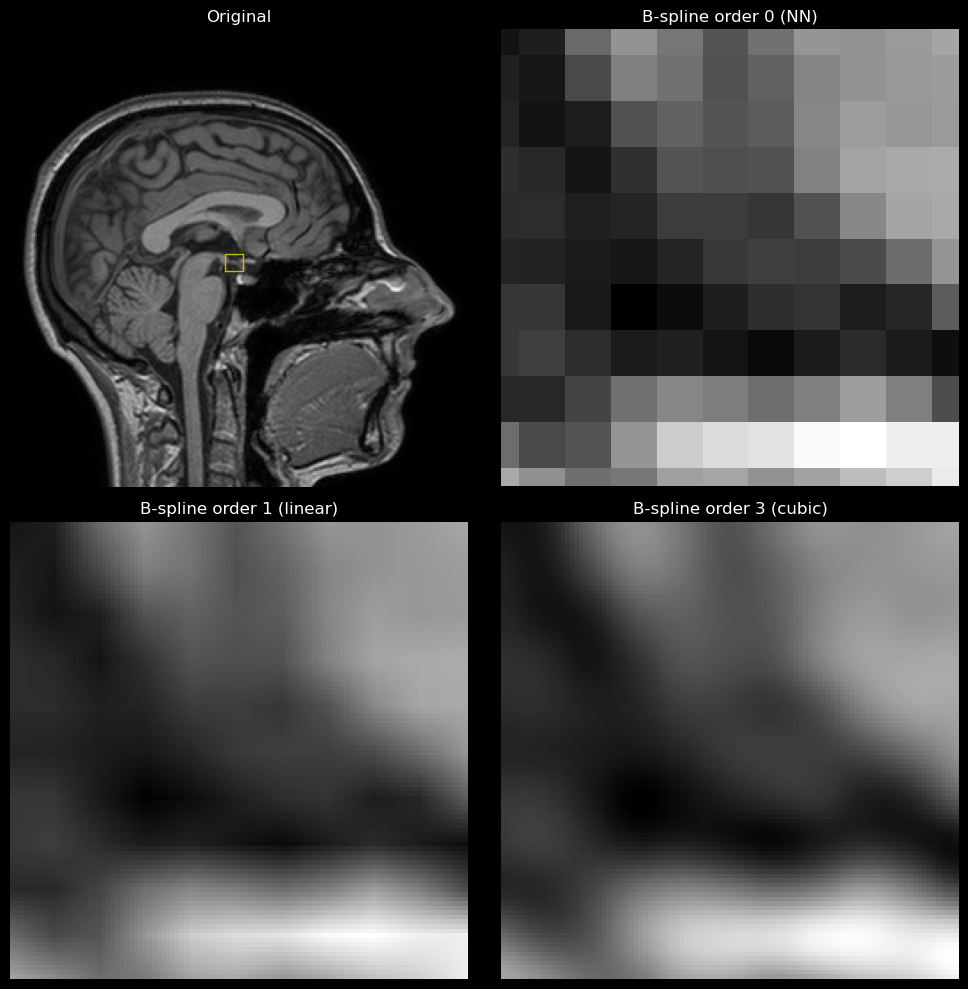

In [18]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()  # flatten to 1D for easy indexing

# Extract Roi
extent_T  = (0, N-1, 0, N-1)
extent_ROI = (x1[0], x1[-1], x1[0], x1[-1])
x0, x1b = x1[0], x1[-1]
y0, y1b = x1[0], x1[-1]  

axs[0].imshow(np.rot90(T,2), cmap='gray', origin='lower', extent=extent_T)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].plot([x0, x1b, x1b, x0, x0],
            [y0, y0,  y1b, y1b, y0],
            lw=1, color='y')


axs[1].imshow(np.rot90(Y0,2), cmap='gray', origin='lower', extent=extent_ROI)
axs[1].set_title('B-spline order 0 (NN)')
axs[1].axis('off')

axs[2].imshow(np.rot90(Y1,2), cmap='gray', origin='lower', extent=extent_ROI)
axs[2].set_title('B-spline order 1 (linear)')
axs[2].axis('off')

axs[3].imshow(np.rot90(Y3,2), cmap='gray', origin='lower', extent=extent_ROI)
axs[3].set_title('B-spline order 3 (cubic)')
axs[3].axis('off')

plt.tight_layout()
plt.show()